In [1]:
import numpy as np
import pandas as pd
from rand_data.make import make_data
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream

%matplotlib inline

In [2]:
# make some random data
df = make_data(
    shape=(5000,2),
    rand_range=(1,10),
    anom_len=500
)
print(df.shape)
stream = DataStream(df)
stream.prepare_for_use()

print(f'n_remaining_samples: {stream.n_remaining_samples()}')
print(f'feature_names: {stream.feature_names}')
print(f'target_names: {stream.target_names}')

(5500, 3)
n_remaining_samples: 5500
feature_names: ['col_0', 'col_1']
target_names: ['is_anom']


In [3]:
# define anomaly detection learner
learner = HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=250, 
    n_estimators=25, 
    size_limit=0.1*250, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5
)

# lists to collect data into
X_vals = []
y_preds = []
y_probs = []

# some params
n = 0
n_burn_in = 250

# process the stream data
while stream.has_more_samples():
    X, y = stream.next_sample()
    # wait until enough burn in data processed
    if n > n_burn_in:
        y_pred = learner.predict(X).tolist()
        y_prob = learner.predict_proba(X).tolist()[0]
        X_vals.append(X.tolist()[0])
        y_preds.append(y_pred)
        y_probs.append(y_prob)
    learner.partial_fit(X, y)
    n += 1

In [4]:
# put results into a df
df_x = pd.DataFrame(X_vals,columns=stream.feature_names)
df_probs = pd.DataFrame(y_probs,columns=[f'prob_{n}' for n in range(len(y_probs[0]))])
df_preds = pd.DataFrame(y_preds,columns=[f'pred_{n}' for n in range(len(y_preds[0]))])
df = pd.concat([df_x,df_probs,df_preds],axis=1)
print(df.shape)
df.head()

(5249, 5)


,col_0,col_1,prob_0,prob_1,pred_0
0,5,3,5.000000e-01,0.5,0
1,4,6,2.441406e-07,1.0,1
2,9,2,2.441406e-07,1.0,1
3,1,1,2.441406e-07,1.0,1
4,6,2,2.441406e-07,1.0,1


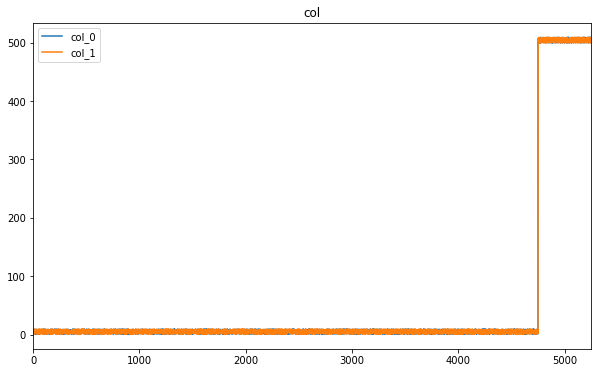

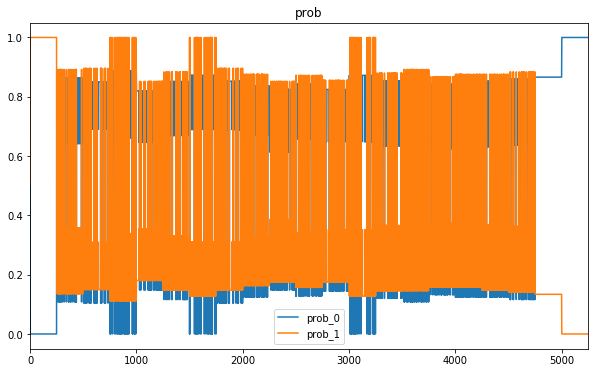

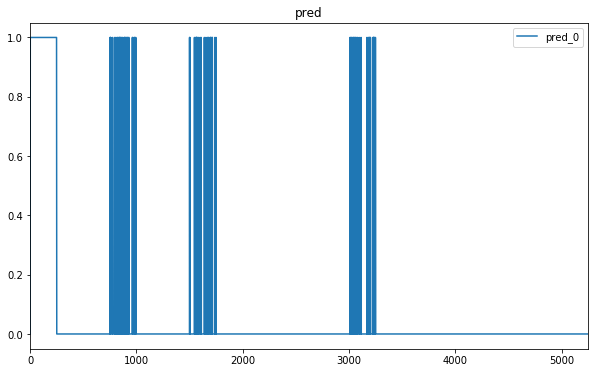

In [5]:
# plot the cols, probs and preds
for prefix in ['col','prob','pred']:
    plot_cols = [col for col in df.columns if prefix in col]
    df[plot_cols].plot(title=prefix, figsize=(10,6))